In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 1.zero_padding

In [2]:
def zero_pad(X, pad):
    """
    作用：给样本集X的所有样本进行零填充
    
    参数：
    X -- 样本集，维度是（m, n_H, n_W, n_c）
    pad -- padding的个数
    
    返回值：
    X_pad -- 返回填补后的样本集。维度是（m, n_H + 2*pad, n_W+ 2*pad, n_c）
    """
    
    #np.pad是numpy提供的一个零补函数
    X_pad = np.pad(X, ((0, 0),(pad, pad),(pad, pad),(0, 0)),'constant',constant_values = 0)
    
    return X_pad

In [3]:
#单元测试
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x, 2)
print('x.shape',x.shape)
print('x_pad.shape',x_pad.shape)
print('x[1,1] :',x[1,1])
print('x_pad[1,1]',x_pad[1,1])

x.shape (4, 3, 3, 2)
x_pad.shape (4, 7, 7, 2)
x[1,1] : [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


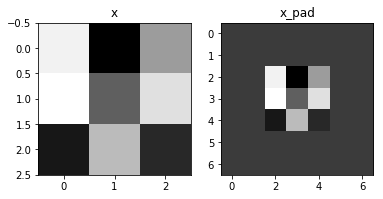

In [4]:
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[1].set_title('x_pad')
axarr[0].imshow(x[0,:,:,0])
axarr[1].imshow(x_pad[0,:,:,0])

## 2.单步卷积

In [5]:
def conv_single_step(a_slice_prev, W, b):
    """
    作用：只执行一步卷积
    
    参数：
    a_slice_prov -- 输入 矩阵中和过滤器卷积的那一块数据
                 -- 这里的输入矩阵也就是上一层的输出矩阵
    W -- 权重参数w。这里指的是过滤器，过滤器就是权重参数w
      -- 维度是（f, f, n_C_prev）,与a_slice_prev是一样的，因为是它俩进行卷积，所以维度是一样的
    b -- 阈值b，教程中我们说过每一个过滤器会有一个对应的阈值 维度是（1，1，1）
    
    返回值：
    Z -- 卷积一步后得到的一个数值，这个数值是一个输出矩阵的一个元素

    """
    #将a_slice_prev与W中的每一个元素进行相乘
    s = np.multiply(a_slice_prev, W) + b
    #将上面相乘的结果累加起来
    Z = np.sum(s)
    
    return Z

In [6]:
#单元测试
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print('Z:',Z)

Z: -23.16021220252078


## 3.前向传播

### 多个过滤器生成矩阵后构建多维矩阵

### 
<center>
    <video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
    </video>
</center>

### 获取子矩阵

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **图 3** </u><font color='purple'>  : **定位子矩阵** <br> </center></caption>

### 计算输出矩阵的维度

$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{这个是过滤器的个数}$$

In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积网络的前向传播
    
    参数：
    A_prev -- 本层的输入矩阵，也就是上一层的输出矩阵。
           -- 维度是（m, n_H_prev, n_W_prev, n_C_prev）
    W -- 权重，也就是过滤器。维度是（f, f, n_C_prev, n_C），n_C表示过滤器的个数
    b -- 阈值，维度是（1，1，1，n_C）。一个过滤器一个阈值
    hparameters -- 数组参数步长stride数s和padding数p
    
    返回值：
    Z -- 输出矩阵，也就是卷积结果。维度是（m, n_H, n_W, n_C）
    cache -- 缓存一些数值， 以供反向传播时用
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride'] # 步长s
    pad = hparameters['pad'] # 填补数量p
    
    # 计算输出矩阵的维度。参考上面提供的公式    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1 # 使用int()来实现向下取整
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 初始化输出矩阵
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # 给输入矩阵进行padding填补0
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                 # 遍历每一个样本
        a_prev_pad = A_prev_pad[i]                     # 取出一个样本对应的输入矩阵
        for h in range(n_H):                           # 遍历输出矩阵的高
            for w in range(n_W):                       # 遍历输出矩阵的宽
                for c in range(n_C):                   # 遍历每一个过滤器
                    # 计算出输入矩阵中本次应该卷积的区域的索引，然后通过这些索引取出将被卷积的小块数据。
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # 利用之前我们实现的conv_single_step函数来对这块数据进行卷积。
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    assert(Z.shape == (m, n_H, n_W, n_C))
 
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [8]:
#单元测试
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {'pad' : 2,
               'stride' : 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean = ",np.mean(Z))
print("cache_conv[0][1][2][3] = ",cache_conv[0][1][2][3])

Z's mean =  0.15585932488906465
cache_conv[0][1][2][3] =  [-0.20075807  0.18656139  0.41005165]


## 池化层

### 池化的前向传播

下面实现一个池化的前向传播，可以指定用最大池化还是平均池化。
计算输出矩阵的维度公式会与卷积层的有所不同，因为没有padding：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [12]:
def pool_forward(A_prev,hparameters, mode = 'max'):
    """
    实现池化的前向传播
    
    参数：
    A_prev
    hparameters
    mode -- 池化模式，最大池化就写max，平均池化就写average
    
    返回值：
    A -- 池化层的输出矩阵，维度（m, n_H, n_W, n_C）
    cache
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    #窗口大小
    f = hparameters['f']
    stride = hparameters['stride']
    
    #计算输出矩阵的大小
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C =n_C_prev
    
    #初始化输出矩阵
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    #根据mode，执行池化
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache    

In [13]:
#单元测试
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {'stride' : 1, 'f' : 4}

A, cache = pool_forward(A_prev, hparameters)
print('mode = max')
print('A =', A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = 'average')
print('mode = average')
print('A =', A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


# 以上完成了CNN的前向传播

## CNN的反向传播


### 卷积层的反向传播
1.计算某个样本的某个过滤器的dA:
$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

$W_c$是表示这个过滤器。

这个公式对应的python代码如下：
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

2.计算某个过滤器的dW:
$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

$a_{slice}$表示输入矩阵中的被卷积的子矩阵。

上面的公式对应于下面的python代码:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

3.计算某个过滤器的db:
$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

上面的公式对应于下面的python代码:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

In [14]:
def conv_backward(dZ, cache):
    """    
    参数:
    dZ -- 后一层相关的dZ，维度是(m, n_H, n_W, n_C)
    cache -- 前面的conv_forward()函数保存下来的缓存数据
    
    Returns:
    dA_prev -- 本卷积层输入矩阵的dA，维度是(m, n_H_prev, n_W_prev, n_C_prev)
    dW -- 本卷积层相关的dW,维度是(f, f, n_C_prev, n_C)
    db -- 本卷积层相关的db,维度是(1, 1, 1, n_C)
    """

    (A_prev, W, b, hparameters) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"] # 步长
    pad = hparameters["pad"] # padding数量
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # 遍历每一个样本
        
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # 遍历输出矩阵的高
            for w in range(n_W):               # 遍历输出矩阵的宽
                for c in range(n_C):           # 遍历输出矩阵的深度
                    
                    # 计算输入矩阵中的子矩阵的索引
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # 取出当前进行卷积的子矩阵
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # 用上面的公式来计算偏导数
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [15]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))
# print(dA.shape)

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


### 池化层最大池化的反向传播
在实现池化层之前，我们需要先实现两个工具函数，第一个是 `create_mask_from_window()`，它可以根据输入矩阵得到一个特殊的输出矩阵，这个输出矩阵中只有最大值处是1，其余都是零。如下所示，X是输入矩阵，M是函数的输出矩阵: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

提示:
- [np.max()]()会返回矩阵中的最大元素。
- python语法`A = (X == x)`会生成一个矩阵A，这个A与X的维度是一样的，A里面其它元素都为0，只有与小x的值相同的位置处为1，也就是为True。python中0等于False，1等于True:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```

In [23]:
def create_mask_from_windows(x):
    
    #x是一个矩阵。np.max(x)会得到最大的元素
    #mask是一个与x维度相同的矩阵,可以理解为mask先是被x赋值，
    #然后看里面的元素是不是等于max（x）的值
    mask = (x == np.max(x))
    
    return mask

In [24]:
#单元测试
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_windows(x)
print('x = ', x)
print('mask = ', mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


### 池化层平均池化的反向传播
为了实现最大池化的反向传播，我们需要实现如下的工具函数`distribute_value`。就是把一个数值平分成一个矩阵，例如把1平分成四分之一到一个矩阵中: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

In [25]:
def distribute_value(dz, shape):
    """
    dz -- 一个数
    shape -- 输出矩阵的维度
    
    返回值：
    a -- a的维度就是shape，里面的值由dz平分而来的
    """
    
    (n_H, n_W) = shape
    
    #计算平均值
    average = dz / (n_H * n_W)
    
    #构建输出矩阵
    a = np.ones(shape) * average
    
    return a

In [26]:
a = distribute_value(2, (2, 2))
print('distributed_value = ', a)

distributed_value =  [[0.5 0.5]
 [0.5 0.5]]


In [29]:

def pool_backward(dA, cache, mode = "max"):
    """
    参数:
    dA -- 本池化层的输出矩阵对应的偏导数
    cache -- 前向传播时缓存起来的数值
    mode -- 是最大池化还是平均池化，("max" 或 "average")
    
    Returns:
    dA_prev -- 本池化层的输入矩阵对应的偏导数
    """

    # A_prev是本池化层的输入矩阵
    (A_prev, hparameters) = cache
    
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                     
        a_prev = A_prev[i]
        for h in range(n_H):                  
            for w in range(n_W):             
                for c in range(n_C):          
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_windows(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [30]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
